# ML Project A.Y. 24/25

## Introduction

This project aims at conducting a sentiment analysis about tweets, classifying them as either positive or negative. For the sake of this task, two LSTM-based models will be deployed, with different configurations as to highlight the core differences between the unlike approaches. 

As we delve into this exploration, we'll meticulously navigate through the following key stages:

* **Data loading**: We'll first load the data and use a percentage ratio to split it accordingly.
* **Data preprocessing**: We'll meticulously preprocess the data, encompassing different kinds of text cleaning.
* **Building the model**: We'll construct a simple LSTM-based model as a first approach.
* **Training the model**: We'll train it by exploring its different configurations to get a general idea of how it behaves.
* **More complex model**: We'll delve into a more complex approach and its different configurations, this time based on BiLSTM.
* **Visualization and Evaluation**: We'll visualize the training history to gain insights into the model's learning process and evaluate its performance on the unseen test data to assess its generalization ability.
* **Further testing**: We'll create some tweets on our own and check whether the final model is able to correctly predict their classification.


Let's first introduce the essential libraries we'll need to tackle our sentiment analysis task:

* **math**: This is mainly needed to split the remaining portion of our data into validation and test set.
* **NumPy (np)**: Provides efficient numerical computation capabilities.
* **OS (os)**: Facilitates interaction with the operating system for file and directory operations.
* **matplotlib**: Provides the means to visualize training history.
* **Regular Expressions (re)**: Offers powerful text processing and pattern matching functionalities.
* **string**: Also mainly for text preprocessing.
* **Tensorflow (tf)**: The core deep learning framework powering the sentiment analysis model.
* **ScikitLearn**: To evaluate the model's accuracy, precision, recall and f1 score metrics.
* **rich**: Python library to format text and make it more stylish.

In [1]:
import math
import matplotlib.pyplot as plt
import numpy as np
from numpy import asarray
from numpy import zeros
import string
import tensorflow as tf
from tensorflow.keras.utils import text_dataset_from_directory
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from rich.table import Table
from rich.console import Console
import os

In [2]:
devices = tf.config.list_physical_devices()
print("\nDevices: ", devices)

gpus = tf.config.list_physical_devices('GPU')
if gpus:
  details = tf.config.experimental.get_device_details(gpus[0])
  print("GPU details: ", details)

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 


Devices:  [PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
GPU details:  {'device_name': 'METAL'}


## Data Loading

The data is extracted from the zip file and further split into training, validation and test set. 70% of the dataset will be used for the training phase, the remaining 30% is split in half and assigned to the other two sets. 
The following paths are used for data management goals:
* **DATASET_ZIP**: `/Users/matteoavallone/Downloads/TwitterParsed.zip` is the location where the compressed dataset can be found.
* **DATASET_EXTRACT_DIR**: `/Users/matteoavallone/Downloads/dataset` is the location where the extracted dataset will be stored.

`text_dataset_from_directory` is used to extract the dataset and split it into 70% of training set and 30% of validation_and_test set.

The validation_and_test set is further split thanks to the `math.floor()` function as stated before.

Lastly, some example have been displayed. 

In [4]:
import zipfile

DATASET_ZIP = '/Users/matteoavallone/Downloads/TwitterParsed.zip'
DATASET_EXTRACT_DIR = '/Users/matteoavallone/Downloads/dataset'
validation_split = 0.15
test_split = 0.15

os.makedirs(DATASET_EXTRACT_DIR, exist_ok=True)

with zipfile.ZipFile(DATASET_ZIP, 'r') as zip_ref:
    zip_ref.extractall(DATASET_EXTRACT_DIR)

DATASET_DIR = os.path.join(DATASET_EXTRACT_DIR, "TwitterParsed")

raw_train_ds = text_dataset_from_directory(
    DATASET_DIR,
    batch_size=32,         
    validation_split=0.3,  
    subset='training',     
    seed=42               
)

raw_val_and_test_ds = text_dataset_from_directory(
    DATASET_DIR,
    batch_size=32,
    validation_split=0.3,
    subset='validation',
    seed=42
)


val_size = math.floor(
        (validation_split / (validation_split + test_split)) * len(raw_val_and_test_ds)
)

raw_val_ds = raw_val_and_test_ds.take(val_size)
raw_test_ds = raw_val_and_test_ds.skip(val_size)

print("Class names:", raw_train_ds.class_names)
for text_batch, label_batch in raw_train_ds.take(1):
    for i in range(10):
        print(f"Text: {text_batch.numpy()[i]}")
        print(f"Label: {label_batch.numpy()[i]}")

Found 149985 files belonging to 2 classes.
Using 104990 files for training.
Found 149985 files belonging to 2 classes.
Using 44995 files for validation.
Class names: ['0', '1']
Text: b"blip is sucking....wont post what i'm listening to"
Label: 0
Text: b'is online doing nothing but wishing she had a keyboard on her cell.'
Label: 0
Text: b'Doodoo... I think my hair color is fading already'
Label: 0
Text: b'My new Twitter background is NOT the one I chose!  Trying another one.'
Label: 0
Text: b'Shame have to work today. But the sun is shining, door is open, and a warm(ish) breeze is ambling in. One thing missing - biscuits'
Label: 0
Text: b'@tehtinar I had strawberries but I eated them.'
Label: 0
Text: b'Sh** home from party, and my fathers car has gone to hell...without car, work, ...  Sometimes I guess what people call easy...'
Label: 0
Text: b"Hey guys I'm going to create an iPhone app that's a twitter client called Tweetilicious please @reply me your thoughts!"
Label: 1
Text: b'is goi

### Label distribution

We're also showing the label distribution of our dataset; as it can be seen, it is pretty balanced, accounting for a nearly perfect 50% split of positive and negative tweets.

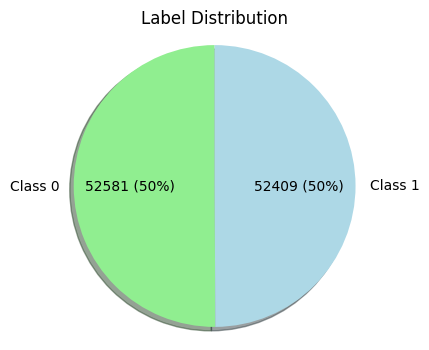

In [5]:
from collections import Counter

label_list = []
for _, labels in raw_train_ds:
    label_list.extend(labels.numpy())

# Count label occurrences
label_distribution = Counter(label_list)

labels = list(label_distribution.keys()) 
sizes = list(label_distribution.values())  # Counts for each label

label_names = [f"Class {label}" for label in labels]

# Plot the pie chart
plt.figure(figsize=(4, 4))
plt.pie(sizes, labels=label_names, shadow=True, autopct=lambda p: '{:.0f} ({:.0f}%)'.format(p * sum(sizes) / 100, p), startangle=90, colors=['lightgreen', 'lightblue'])
plt.title('Label Distribution')
plt.axis('equal')  
plt.show()

## Data Pre-processing

To get the data into the proper form to feed into the network, some pre-processing is applied to it. This is done in order to clean and prepare the data for classification.
The `twitter_cleaner` function handles all the essential steps involved in the process:

1. **lowercase**: converts all the words to lowercase format.
2. **remove_unwanted_chars**: makes use of regular expression in order to wipe out punctuations (except for '@'), URLs and mentions ('@' followed by a twitter username).
3. **replace_slang**: expands common slang words to their original words.
4. **substitute_emoticons**: converts emoticons to a word format as to preserve their meaning.
5. **clean_whitespaces**: removes white spaces from anywhere in the text, even trailing or leading spaces.

`slang_dict` is a dictionary of the most common english slang words: its keys are regular expressions that ease the lookup process and its values are the corresponding correct form or meaning of the words.

The final step consists of applying the `preprocess_dataset` function to every element of the training, validation and test sets.

In [5]:
slang_dict = {
    r"\bbrb\b": "be right back",
    r"\bomg\b": "oh my god",
    r"\blol\b": "laugh out loud",
    r"\bidk\b": "I don't know",
    r"\bsmh\b": "shaking my head",
    r"\btho\b": "though",
    r"\bwanna\b": "want to",
    r"\bgonna\b": "going to",
    r"\bwont\b": "will not",
    r"\bchill\b": "calm down",
    r"\basap\b": "as soon as possible",
    r"\bkinda\b": "kind of",
    r"\blame\b": "boring",
    r"\bgotta\b": "got to",
    r"\bfyi\b": "for your information",
    r"\boutta\b": "out of",
    r"\blit\b": "exciting",
    r"\bbff\b": "best friend",
    r"\boomf\b": "one of my followers",
    r"\bhella\b": "extremely",
    r"\bmeh\b": "mediocre",
    r"\bnah\b": "no",
    r"\bgimme\b": "give me",
    r"\byup\b": "yes",
    r"\b4word\b": "forward",
    r"\b2moro\b": "tomorrow"
}

eyes = r"[:;]"
nose = r"[-]?"

def lowercase(text):
    return tf.strings.lower(text)

def replace_slang(text):
    for slang, replacement in slang_dict.items():
        text = tf.strings.regex_replace(text, slang, replacement)
    return text

def remove_unwanted_chars(text):   
    punctuation_pattern = r"[^\w\s@]|_"
    text = tf.strings.regex_replace(text, punctuation_pattern, "")

    url_pattern = r"https?\S+|www\S+https\S+"
    text = tf.strings.regex_replace(text, url_pattern, "")

    mention_pattern = r"@[A-Za-z0-9]+"
    text = tf.strings.regex_replace(text, mention_pattern, "")

    return text

def clean_whitespaces(text):
    multiple_spaces_pattern = r"\s+"
    text = tf.strings.regex_replace(text, multiple_spaces_pattern, ' ')
    
    leading_trailing_pattern = r"^\s+|\s+$"
    text = tf.strings.regex_replace(text, leading_trailing_pattern, '')
    return text

def substitute_emoticons(text):
    # Replace smiley faces with <SMILE>
    text = tf.strings.regex_replace(text, rf"{eyes}{nose}[)d]+|[)d]+{nose}{eyes}", "<SMILE> ")

    # Replace laughing faces with <LOLFACE>
    text = tf.strings.regex_replace(text, rf"{eyes}{nose}p+", "<LOLFACE> ")

    # Replace sad faces with <SADFACE>
    text = tf.strings.regex_replace(text, rf"{eyes}{nose}\(+|\)+{nose}{eyes}", "<SADFACE> ")

    # Replace neutral faces with <NEUTRALFACE>
    text = tf.strings.regex_replace(text, rf"{eyes}{nose}[\/|l]*", "<NEUTRALFACE> ")

    # Replace hearts with <HEART>
    text = tf.strings.regex_replace(text, r"<3", "<HEART> ")
    return text

def twitter_cleaner(text):
    text = lowercase(text)
    text = remove_unwanted_chars(text)
    text = replace_slang(text)
    text = substitute_emoticons(text)
    text = clean_whitespaces(text)
    return text

def preprocess_dataset(text, label):
    processed_text = twitter_cleaner(text)
    return processed_text, label

train_ds = raw_train_ds.map(preprocess_dataset)
val_ds = raw_val_ds.map(preprocess_dataset)
test_ds = raw_test_ds.map(preprocess_dataset)

In [6]:
for text_batch, label_batch in train_ds.take(1):
    for i in range(10):
        print(f"Text: {text_batch.numpy()[i]}")
        print(f"Label: {label_batch.numpy()[i]}")


Text: b'is it just me or is anyone else been slow at getting subscribers lately ive only been getting about 5 or less a day its discouraging'
Label: 0
Text: b'he must think theres something special about you'
Label: 1
Text: b'your guess is as good as mine totally freaked me out when it rang'
Label: 1
Text: b'needed advice on the best place in the city to check out the moon that i can actually get to like not the cn tower'
Label: 1
Text: b'true true crud that means ill have to wait until tonight'
Label: 0
Text: b'i think that is awesome she peobably sensed mimi inutero'
Label: 1
Text: b'just uploading season 1 in the video directory on me web site love it see good laugh'
Label: 1
Text: b'twitter has stolen my face'
Label: 0
Text: b'tell me more abou nyc on here or fbook i cant text very much in sverige'
Label: 0
Text: b'yes the former chef chan at odeon towers has nice modern oriental feel not sure about the new location at national museum'
Label: 1


## Building the model

We start by defining a simple LSTM-based model; to explore its different configurations and thus analyse its performance, `lstm_model` allows us to vary the vocabulary size, the input sequence length, the number of units in the LSTM layer and finally choose whether to apply for a regular or a bidirectional LSTM.

We create the `vectorizationLayer` that converts words into tokens (integers); `max_tokens` and `output_sequence_length` are two of the hyperparamaters chosen when defining a model configuration: we usually consider a maximum vocabulary size ranging from 5000 to 20000, and an output sequence length between 25 and 50. 

We then add an `embedding_layer` to the model to convert the vectorized output of textual data into dense, continuous vectors. This often helps the language model to capture semantic meaning and contextual relationships within the text. We fix the embedding dimension to 128 and vary the vocabulary size.

Depending on the value of `bidirectional`, we add a BiLSTM or LSTM layer to the model, specifying the number of units as hyperparameter. 
Finally, a `Dense` layer is added to map the output of the (Bi)LSTM layer to a desidered output size, with the sigmoid activation function to turn all the output values in the range 0 to 1. 

The last steps involve compiling, fitting and get a summary of the model: to compile it, we choose the **Adam** optimization algorithm, which leverages past gradient information to accelerate convergence. To fit the model we specify two `keras.callbacks.Callback` instances: one being **early stopping**, monitoring the validation loss with a patience of 2, and the other being the user-defined **PrintBestValAccuracy**, that prints the best validation accuracy obtained from the training phase.

In [7]:
def lstm_model(train_ds, val_ds, vocab_size, seq_length, units, bidirectional):

    vectorizationLayer = tf.keras.layers.TextVectorization(
        max_tokens=vocab_size,
        output_mode='int',
        output_sequence_length=seq_length)
    train_text = train_ds.map(lambda x, y: x)
    vectorizationLayer.adapt(train_text)

    embedding_layer = tf.keras.layers.Embedding(vocab_size, 128)

    model = tf.keras.models.Sequential()
    model.add(vectorizationLayer)
    model.add(embedding_layer)
    if bidirectional:
        model.add(tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(units)))
    else:
        model.add(tf.keras.layers.LSTM(units))
    model.add(tf.keras.layers.Dense(1, activation='sigmoid'))

    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

    model.fit(train_ds,
              epochs=7,
              verbose=1,
              callbacks=[tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=2, restore_best_weights=True), PrintBestValAccuracy()],
              validation_data=val_ds)

    model.summary()
    return model   

class PrintBestValAccuracy(tf.keras.callbacks.Callback):
    def __init__(self):
        super(PrintBestValAccuracy, self).__init__()
        self.best_val_accuracy = 0.0
        self.prev_val_loss = float("inf")

    def on_epoch_end(self, epoch, logs=None):
        val_accuracy = logs.get("val_accuracy")
        val_loss = logs.get("val_loss")
        if val_accuracy > self.best_val_accuracy and val_loss < self.prev_val_loss:  
            self.best_val_accuracy = val_accuracy
            self.prev_val_loss = val_loss 

    def on_train_end(self, logs=None):
        print(f"Training Complete! Restoring Best Validation Accuracy: {self.best_val_accuracy}")


## Train the model

### Configuration 1

We start with a simple 64-units LSTM configuration with limited vocabulary size: a validation accuracy of **78%** is obtained, with **80%** of training accuracy.

In [21]:
first_model = lstm_model(train_ds, val_ds, 5000, 50, 64, False)

Epoch 1/7
3281/3281 ━━━━━━━━━━━━━━━━━━━━ 73s 21ms/step - accuracy: 0.5134 - loss: 0.6903 - val_accuracy: 0.7527 - val_loss: 0.5189
Epoch 2/7
3281/3281 ━━━━━━━━━━━━━━━━━━━━ 75s 23ms/step - accuracy: 0.7710 - loss: 0.4811 - val_accuracy: 0.7907 - val_loss: 0.4506
Epoch 3/7
3281/3281 ━━━━━━━━━━━━━━━━━━━━ 76s 23ms/step - accuracy: 0.8099 - loss: 0.4135 - val_accuracy: 0.7897 - val_loss: 0.4687
Epoch 4/7
3281/3281 ━━━━━━━━━━━━━━━━━━━━ 81s 25ms/step - accuracy: 0.8270 - loss: 0.3798 - val_accuracy: 0.7862 - val_loss: 0.4963
Training Complete! Restoring Best Validation Accuracy: 0.7906739115715027


Model: "sequential_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ text_vectorization_10           │ (None, 50)             │             0 │
│ (TextVectorization)             │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding_10 (Embedding)        │ (None, 50, 128)        │       640,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_10 (LSTM)                  │ (None, 64)             │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,068,421 (7.89 MB)

 Trainable params: 689,473 (2.63 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 1,378,948 (5.26 MB)

### Configuration 2

Basically the same configuration as before but with a BiLSTM layer instead: a best validation accuracy of **79%** is obtained, although a training accuracy of **73%** might suggest that the model is slightly underfitting.

In [10]:
second_model = lstm_model(train_ds, val_ds, 5000, 50, 64, True)

Epoch 1/7
3281/3281 ━━━━━━━━━━━━━━━━━━━━ 189s 57ms/step - accuracy: 0.7330 - loss: 0.5241 - val_accuracy: 0.7953 - val_loss: 0.4428
Epoch 2/7
3281/3281 ━━━━━━━━━━━━━━━━━━━━ 173s 53ms/step - accuracy: 0.7997 - loss: 0.4264 - val_accuracy: 0.7945 - val_loss: 0.4446
Epoch 3/7
3281/3281 ━━━━━━━━━━━━━━━━━━━━ 174s 53ms/step - accuracy: 0.8183 - loss: 0.3927 - val_accuracy: 0.7895 - val_loss: 0.4660
Training Complete! Restoring Best Validation Accuracy: 0.7953413724899292


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ text_vectorization_1            │ (None, 50)             │             0 │
│ (TextVectorization)             │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding_1 (Embedding)         │ (None, 50, 128)        │       640,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (None, 128)            │        98,816 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,216,837 (8.46 MB)

 Trainable params: 738,945 (2.82 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 1,477,892 (5.64 MB)

### Configuration 3

Same as configuration 1 but with a halved input sequence length: here, training and validation accuracies seem to be more balanced, with a total gap of more or less 0,50.

In [12]:
third_model = lstm_model(train_ds, val_ds, 5000, 25, 64, False)

2025-02-02 17:02:06.271044: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 1/7
3281/3281 ━━━━━━━━━━━━━━━━━━━━ 57s 17ms/step - accuracy: 0.7206 - loss: 0.5416 - val_accuracy: 0.7889 - val_loss: 0.4527
Epoch 2/7
3281/3281 ━━━━━━━━━━━━━━━━━━━━ 60s 18ms/step - accuracy: 0.7977 - loss: 0.4337 - val_accuracy: 0.7924 - val_loss: 0.4483
Epoch 3/7
3281/3281 ━━━━━━━━━━━━━━━━━━━━ 53s 16ms/step - accuracy: 0.8162 - loss: 0.4012 - val_accuracy: 0.7869 - val_loss: 0.4708
Epoch 4/7
3281/3281 ━━━━━━━━━━━━━━━━━━━━ 58s 18ms/step - accuracy: 0.8354 - loss: 0.3650 - val_accuracy: 0.7768 - val_loss: 0.5152
Training Complete! Restoring Best Validation Accuracy: 0.7923631072044373


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ text_vectorization_3            │ (None, 25)             │             0 │
│ (TextVectorization)             │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding_3 (Embedding)         │ (None, 25, 128)        │       640,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ (None, 64)             │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,068,421 (7.89 MB)

 Trainable params: 689,473 (2.63 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 1,378,948 (5.26 MB)

### Configuration 4

An increased vocab size of 10000 combined with a BiLSTM layer: slight underfit due to almost 7% less training accuracy with respect to validation accuracy.

In [13]:
fourth_model = lstm_model(train_ds, val_ds, 10000, 50, 64, True)

Epoch 1/7
3281/3281 ━━━━━━━━━━━━━━━━━━━━ 193s 57ms/step - accuracy: 0.7299 - loss: 0.5258 - val_accuracy: 0.7948 - val_loss: 0.4415
Epoch 2/7
3281/3281 ━━━━━━━━━━━━━━━━━━━━ 187s 57ms/step - accuracy: 0.8097 - loss: 0.4113 - val_accuracy: 0.7944 - val_loss: 0.4448
Epoch 3/7
3281/3281 ━━━━━━━━━━━━━━━━━━━━ 186s 57ms/step - accuracy: 0.8379 - loss: 0.3602 - val_accuracy: 0.7865 - val_loss: 0.4860
Training Complete! Restoring Best Validation Accuracy: 0.7948079705238342


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ text_vectorization_4            │ (None, 50)             │             0 │
│ (TextVectorization)             │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding_4 (Embedding)         │ (None, 50, 128)        │     1,280,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ (None, 128)            │        98,816 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,136,837 (15.78 MB)

 Trainable params: 1,378,945 (5.26 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2,757,892 (10.52 MB)

### Configuration 5

Same as configuration 4, but with 20000 as vocab size: again we can see the model slightly underfits due to its training accuracy being lower than its validation accuracy by approximately 6%.

In [14]:
fifth_model = lstm_model(train_ds, val_ds, 20000, 50, 64, True)

Epoch 1/7
3281/3281 ━━━━━━━━━━━━━━━━━━━━ 211s 64ms/step - accuracy: 0.7327 - loss: 0.5239 - val_accuracy: 0.7981 - val_loss: 0.4367
Epoch 2/7
3281/3281 ━━━━━━━━━━━━━━━━━━━━ 207s 63ms/step - accuracy: 0.8181 - loss: 0.3987 - val_accuracy: 0.7933 - val_loss: 0.4513
Epoch 3/7
3281/3281 ━━━━━━━━━━━━━━━━━━━━ 219s 67ms/step - accuracy: 0.8553 - loss: 0.3304 - val_accuracy: 0.7766 - val_loss: 0.5326
Training Complete! Restoring Best Validation Accuracy: 0.798052966594696


Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ text_vectorization_5            │ (None, 50)             │             0 │
│ (TextVectorization)             │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding_5 (Embedding)         │ (None, 50, 128)        │     2,560,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_2 (Bidirectional) │ (None, 128)            │        98,816 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,976,837 (30.43 MB)

 Trainable params: 2,658,945 (10.14 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 5,317,892 (20.29 MB)

### Configuration 6

128 hidden units in a BiLSTM layer and 10000 vocabulary size. Again a slight underfit of about 7%.

In [15]:
sixth_model = lstm_model(train_ds, val_ds, 10000, 50, 128, True)

Epoch 1/7
3281/3281 ━━━━━━━━━━━━━━━━━━━━ 208s 63ms/step - accuracy: 0.7255 - loss: 0.5300 - val_accuracy: 0.7965 - val_loss: 0.4379
Epoch 2/7
3281/3281 ━━━━━━━━━━━━━━━━━━━━ 204s 62ms/step - accuracy: 0.8108 - loss: 0.4114 - val_accuracy: 0.7939 - val_loss: 0.4448
Epoch 3/7
3281/3281 ━━━━━━━━━━━━━━━━━━━━ 196s 60ms/step - accuracy: 0.8366 - loss: 0.3637 - val_accuracy: 0.7882 - val_loss: 0.4838
Training Complete! Restoring Best Validation Accuracy: 0.7964971661567688


Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ text_vectorization_6            │ (None, 50)             │             0 │
│ (TextVectorization)             │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding_6 (Embedding)         │ (None, 50, 128)        │     1,280,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_3 (Bidirectional) │ (None, 256)            │       263,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,630,277 (17.66 MB)

 Trainable params: 1,543,425 (5.89 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 3,086,852 (11.78 MB)

We can see that almost all the configurations tend to underfit the training data, meaning that the model might not be complex enough to capture data patterns/relationships between features and labels.

## More complex model

Due to the previous model being too simple for our sentiment analysis task, we delve into a more complex approach. The vectorization and embedding layers are defined in the same way as before; we now have:
* A **fixed BiLSTM layer** with number of units as hyperparameter.
* A **Normalization layer (LayerNorm)**.
* A **Dense layer with 128 units** and `relu` as activation function.
* **Another Normalization layer (LayerNorm)**.
* A final Dense layer with sigmoid activation function.

In this more complex approach, we focus on a BiLSTM layer in order to better capture long-range dependencies, since it reads input both forward and backward. This can be particularly beneficial for understanding the sentiment of a tweet, as words often carry different meanings depending on their surrounding context.

Two LayerNorms are added after the BiLSTM and Dense layers respectively: these help in stablizing and accelerating training by normalizing the inputs to each layer; it ensures that the model processes information consistently, regardless of the input’s scale or distribution. 
We don't use a BatchNorm layer since it normalizes each feature within a batch of samples; LayerNorm, on the other hand, normalizes all features within each sample and is thus more suitable for a RNN; this is because the different features of a single sample are actually the variations in words over time, and the feature relationships within the sample are very close.

The fully connected dense layer provides non-linearity and allows the model to learn higher-level representations.

We use a different optimization algorithm, `rmsprop`, that generally works well with models prone to vanishing or exploding gradients and may have less computational overhead with respect to Adam due to the absence of momentum.

In [12]:
def alt_model(train_ds, val_ds, vocab_size, seq_length, units):

    vectorizationLayer = tf.keras.layers.TextVectorization(
        max_tokens=vocab_size,
        output_mode='int',
        output_sequence_length=seq_length)
    train_text = train_ds.map(lambda x, y: x)
    vectorizationLayer.adapt(train_text)

    embedding_layer = tf.keras.layers.Embedding(vocab_size, 128)

    model = tf.keras.models.Sequential()
    model.add(vectorizationLayer)
    model.add(embedding_layer)
    model.add(tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(units)))
    model.add(tf.keras.layers.LayerNormalization())
    model.add(tf.keras.layers.Dense(128, activation='relu'))
    model.add(tf.keras.layers.LayerNormalization())
    model.add(tf.keras.layers.Dense(1, activation='sigmoid'))

    model.compile(loss='binary_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

    history = model.fit(train_ds,
              epochs=7,
              verbose=1,
              callbacks=[tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=2, restore_best_weights=True), PrintBestValAccuracy()],
              validation_data=val_ds)

    return model, history 

In [16]:
first_config, history1 = alt_model(train_ds, val_ds, 10000, 50, 64)

Epoch 1/7
3281/3281 ━━━━━━━━━━━━━━━━━━━━ 244s 74ms/step - accuracy: 0.7077 - loss: 0.5633 - val_accuracy: 0.7820 - val_loss: 0.4640
Epoch 2/7
3281/3281 ━━━━━━━━━━━━━━━━━━━━ 212s 65ms/step - accuracy: 0.7877 - loss: 0.4530 - val_accuracy: 0.7949 - val_loss: 0.4430
Epoch 3/7
3281/3281 ━━━━━━━━━━━━━━━━━━━━ 211s 64ms/step - accuracy: 0.8038 - loss: 0.4260 - val_accuracy: 0.7977 - val_loss: 0.4366
Epoch 4/7
3281/3281 ━━━━━━━━━━━━━━━━━━━━ 214s 65ms/step - accuracy: 0.8177 - loss: 0.4065 - val_accuracy: 0.7940 - val_loss: 0.4446
Epoch 5/7
3281/3281 ━━━━━━━━━━━━━━━━━━━━ 208s 63ms/step - accuracy: 0.8272 - loss: 0.3904 - val_accuracy: 0.7930 - val_loss: 0.4443
Training Complete! Restoring Best Validation Accuracy: 0.7976973652839661


In [17]:
second_config, history2 = alt_model(train_ds, val_ds, 20000, 50, 64)

Epoch 1/7
3281/3281 ━━━━━━━━━━━━━━━━━━━━ 230s 68ms/step - accuracy: 0.7138 - loss: 0.5559 - val_accuracy: 0.7839 - val_loss: 0.4598
Epoch 2/7
3281/3281 ━━━━━━━━━━━━━━━━━━━━ 236s 72ms/step - accuracy: 0.7925 - loss: 0.4478 - val_accuracy: 0.7932 - val_loss: 0.4446
Epoch 3/7
3281/3281 ━━━━━━━━━━━━━━━━━━━━ 237s 72ms/step - accuracy: 0.8083 - loss: 0.4170 - val_accuracy: 0.7962 - val_loss: 0.4424
Epoch 4/7
3281/3281 ━━━━━━━━━━━━━━━━━━━━ 225s 68ms/step - accuracy: 0.8253 - loss: 0.3913 - val_accuracy: 0.8002 - val_loss: 0.4419
Epoch 5/7
3281/3281 ━━━━━━━━━━━━━━━━━━━━ 223s 68ms/step - accuracy: 0.8419 - loss: 0.3685 - val_accuracy: 0.7950 - val_loss: 0.4498
Epoch 6/7
3281/3281 ━━━━━━━━━━━━━━━━━━━━ 236s 72ms/step - accuracy: 0.8543 - loss: 0.3472 - val_accuracy: 0.7906 - val_loss: 0.4694
Training Complete! Restoring Best Validation Accuracy: 0.8001866936683655


In [18]:
third_config, history3 = alt_model(train_ds, val_ds, 10000, 50, 128)

Epoch 1/7
3281/3281 ━━━━━━━━━━━━━━━━━━━━ 223s 67ms/step - accuracy: 0.7042 - loss: 0.5722 - val_accuracy: 0.7683 - val_loss: 0.4867
Epoch 2/7
3281/3281 ━━━━━━━━━━━━━━━━━━━━ 212s 64ms/step - accuracy: 0.7875 - loss: 0.4528 - val_accuracy: 0.7918 - val_loss: 0.4474
Epoch 3/7
3281/3281 ━━━━━━━━━━━━━━━━━━━━ 217s 66ms/step - accuracy: 0.8040 - loss: 0.4260 - val_accuracy: 0.7962 - val_loss: 0.4404
Epoch 4/7
3281/3281 ━━━━━━━━━━━━━━━━━━━━ 218s 67ms/step - accuracy: 0.8159 - loss: 0.4081 - val_accuracy: 0.7975 - val_loss: 0.4384
Epoch 5/7
3281/3281 ━━━━━━━━━━━━━━━━━━━━ 219s 67ms/step - accuracy: 0.8264 - loss: 0.3929 - val_accuracy: 0.7966 - val_loss: 0.4401
Epoch 6/7
3281/3281 ━━━━━━━━━━━━━━━━━━━━ 215s 65ms/step - accuracy: 0.8354 - loss: 0.3794 - val_accuracy: 0.7941 - val_loss: 0.4486
Training Complete! Restoring Best Validation Accuracy: 0.7975195646286011


In [19]:
fourth_config, history4 = alt_model(train_ds, val_ds, 10000, 35, 64)

Epoch 1/7
3281/3281 ━━━━━━━━━━━━━━━━━━━━ 201s 60ms/step - accuracy: 0.7121 - loss: 0.5591 - val_accuracy: 0.7817 - val_loss: 0.4649
Epoch 2/7
3281/3281 ━━━━━━━━━━━━━━━━━━━━ 198s 60ms/step - accuracy: 0.7916 - loss: 0.4489 - val_accuracy: 0.7943 - val_loss: 0.4442
Epoch 3/7
3281/3281 ━━━━━━━━━━━━━━━━━━━━ 206s 63ms/step - accuracy: 0.8076 - loss: 0.4224 - val_accuracy: 0.7965 - val_loss: 0.4419
Epoch 4/7
3281/3281 ━━━━━━━━━━━━━━━━━━━━ 217s 66ms/step - accuracy: 0.8209 - loss: 0.4020 - val_accuracy: 0.7956 - val_loss: 0.4446
Epoch 5/7
3281/3281 ━━━━━━━━━━━━━━━━━━━━ 208s 63ms/step - accuracy: 0.8348 - loss: 0.3839 - val_accuracy: 0.7936 - val_loss: 0.4505
Training Complete! Restoring Best Validation Accuracy: 0.7964527010917664


In [20]:
fifth_config, history5 = alt_model(train_ds, val_ds, 15000, 50, 64)

Epoch 1/7
3281/3281 ━━━━━━━━━━━━━━━━━━━━ 240s 72ms/step - accuracy: 0.7068 - loss: 0.5640 - val_accuracy: 0.7788 - val_loss: 0.4650
Epoch 2/7
3281/3281 ━━━━━━━━━━━━━━━━━━━━ 237s 72ms/step - accuracy: 0.7873 - loss: 0.4551 - val_accuracy: 0.7880 - val_loss: 0.4516
Epoch 3/7
3281/3281 ━━━━━━━━━━━━━━━━━━━━ 246s 75ms/step - accuracy: 0.8020 - loss: 0.4274 - val_accuracy: 0.7914 - val_loss: 0.4444
Epoch 4/7
3281/3281 ━━━━━━━━━━━━━━━━━━━━ 238s 73ms/step - accuracy: 0.8163 - loss: 0.4052 - val_accuracy: 0.7944 - val_loss: 0.4430
Epoch 5/7
3281/3281 ━━━━━━━━━━━━━━━━━━━━ 234s 71ms/step - accuracy: 0.8299 - loss: 0.3850 - val_accuracy: 0.7914 - val_loss: 0.4510
Epoch 6/7
3281/3281 ━━━━━━━━━━━━━━━━━━━━ 240s 73ms/step - accuracy: 0.8428 - loss: 0.3656 - val_accuracy: 0.7881 - val_loss: 0.4632
Training Complete! Restoring Best Validation Accuracy: 0.7943634390830994


As it can be seen from the previous configurations, this model behaves better than the simpler one, with the validation accuracy being **80%**, which is generally a good result for a sentiment analysis task involving tweets, since only a small portion of slang words have been handled properly and there may be other factors that prevent it from being higher.
Nonetheless, we stick with this model as it might suit better for more complex datasets and tasks, potentially leading to an enhanced generalization error. 

In [22]:
first_config.summary()

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ text_vectorization_5            │ (None, 50)             │             0 │
│ (TextVectorization)             │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding_5 (Embedding)         │ (None, 50, 128)        │     1,280,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ (None, 128)            │        98,816 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ layer_normalization_2           │ (None, 128)            │           256 │
│ (LayerNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ layer_normalization_3           │ (None, 128)            │           256 │
│ (LayerNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,791,940 (10.65 MB)

 Trainable params: 1,395,969 (5.33 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 1,395,971 (5.33 MB)

## Visualization and Evaluation

In this section, we first visualize the final model's training and validation accuracy/loss, and assess its performance on unseen data (the test set), which was not involved in the training process. This evaluation helps estimate the model's generalization ability to classify sentiment on new, previously unencountered tweets.
We also visualize a table depicting the **accuracy**, **precision**, **recall** and **f1 score** metrics imported from `sklearn.metrics`.

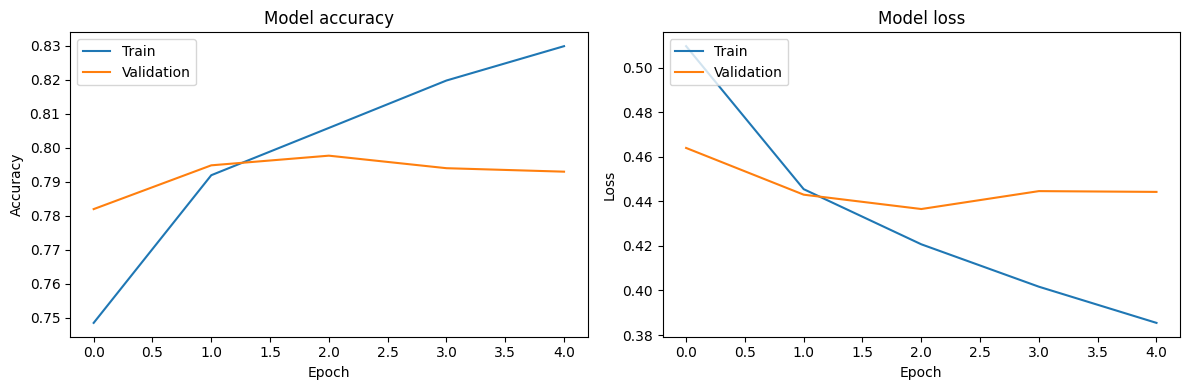

In [24]:
def visualize_train_history(history):
    
    plt.figure(figsize=(12, 4))

    # Plot training & validation accuracy values
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend(['Train', 'Validation'], loc='upper left')

    # Plot training & validation loss values
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend(['Train', 'Validation'], loc='upper left')

    plt.tight_layout()
    plt.show()

visualize_train_history(history1)

In [25]:
first_config.evaluate(test_ds, verbose=1)

704/704 ━━━━━━━━━━━━━━━━━━━━ 24s 30ms/step - accuracy: 0.7960 - loss: 0.4374


[0.4361239969730377, 0.7970132231712341]

In [26]:
MODEL_NAME = "BiLSTM"
console = Console()
    

def unbatch_ds(batched_ds, decode=False, np_array=False):
    X_data = []
    y_data = []
    for x, y in batched_ds.unbatch():
        if decode:
            X_data.append(x.numpy().decode())
        else:
            X_data.append(x.numpy())
        y_data.append(y.numpy())

    if np_array:
        X_data = np.array(X_data)
    else:
        X_data = tf.convert_to_tensor(X_data)

    y_data = np.array(y_data)

    return X_data, y_data
    
def create_rich_table(data, headers, title="Table"):
    table = Table(title=title, show_lines=True)

    for header in headers:
        table.add_column(header, justify="center")

    for row in data:
        table.add_row(*map(str, row))

    return table


def model_evaluation_table(model_name, y_pred, y_test, average="binary"):

    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average=average)
    recall = recall_score(y_test, y_pred, average=average)
    f1 = f1_score(y_test, y_pred, average=average)

    table_data = [
        ("Accuracy", f"{accuracy:.4f}"),
        ("Precision", f"{precision:.4f}"),
        ("Recall", f"{recall:.4f}"),
        ("F1-Score", f"{f1:.4f}"),
    ]

    table = create_rich_table(
        table_data,
        headers=["Metric", "Result"],
        title=MODEL_NAME + " Evaluation Analysis"
    )

    return table


X_test, y_test = unbatch_ds(test_ds)
y_pred = first_config.predict(X_test) 
y_pred = (y_pred > 0.5).astype(int)
eval_table = model_evaluation_table(MODEL_NAME, y_pred, y_test)
console.print(eval_table)

704/704 ━━━━━━━━━━━━━━━━━━━━ 18s 24ms/step


  BiLSTM Evaluation   
       Analysis       
┏━━━━━━━━━━━┳━━━━━━━━┓
┃  Metric   ┃ Result ┃
┡━━━━━━━━━━━╇━━━━━━━━┩
│ Accuracy  │ 0.7972 │
├───────────┼────────┤
│ Precision │ 0.7870 │
├───────────┼────────┤
│  Recall   │ 0.8170 │
├───────────┼────────┤
│ F1-Score  │ 0.8017 │
└───────────┴────────┘

## Further testing

We write our own tweets, create a tf Dataset from them, batch them and check how the model predicts the sentiment.  

In [27]:
own_tweets = [
    "I love this product! It's amazing and works perfectly. #happy",
    "This song is gorgeous!! Can't stop listening lol",
    "it worked out AMAZINGLY!!",
    "Ohhh i'm so happy for you nina #congrats",
    "Made a cake and it tastes delicious!!",
    "This is the worst experience I’ve ever had. Totally disappointed!",
    "The service was very bad, especially the waitress Virginia.",
    "This album tho... not I was expecting at all.",
    "Terrible! Never tasted something so disgusting!",
    "Maybe it's time for me to go to bed.. sad it's over :("
]

X_test = tf.data.Dataset.from_tensor_slices(own_tweets)

X_test = X_test.batch(10) 
predictions = first_config.predict(X_test)

predicted_labels = (predictions > 0.5).astype(int)
print(predicted_labels)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 630ms/step
[[1]
 [1]
 [1]
 [1]
 [1]
 [0]
 [0]
 [0]
 [0]
 [0]]


## Conclusions

Throughout the course of the analysis, it can be observed that the simple model we first built is surely accountable for small-scale datasets; however, keeping our eyes on the more complex BiLSTM-based model is beneficial for more challenging tasks with large-scale datasets.